# Import all the required libraries

In [1]:
import numpy as np
import pandas as pd
from mtcnn import MTCNN
from bs4 import BeautifulSoup
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd
import glob
import os
import cv2
import random as rand

%matplotlib inline

# Prepare the training data

In [2]:
img_path = "images/"
annot_path = "annotations/"

In [3]:
'''
This function is to extract the face coordinates from the xml file
'''
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

In [6]:
'''
Read the annotations .xml file using BeautifulSoup library
Extracting information from the annotations file
The information gathered is converted into the format of pandas dataframe
'''

d = {'image': [], 'Dimensions': []}

img_list = []
dimension_list = []
objects_list = [[] for i in range(115)]

for i in range(1, 116):
    d[f'Object {i}'] = []
for file in os.listdir(annot_path):
    fpath = annot_path + file
    with open(fpath) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        img = soup.find('filename').text
        img_list.append(img)
        
        width, height = int(soup.find("size").find("width").text), int(soup.find("size").find("height").text)
        dimension_list.append([width, height])
        
        objects = soup.find_all("object")
        
        num_objects = 0
        for idx, obj in enumerate(objects):
            label = obj.find("name").text
            box = generate_box(obj)
            objects_list[idx].append([label, box[0], box[1], box[2], box[3]])
            num_objects += 1

        for i in range(num_objects, 115):
            objects_list[i].append(0)

df = pd.DataFrame()
df["image"] = img_list
df["Dimensions"] = dimension_list

for idx, obj_list in enumerate(objects_list):
    df[f"Object {idx+1}"] = obj_list

            



In [7]:
df

,image,Dimensions,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,Object 8,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,maksssksksss0.png,"[512, 366]","[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,maksssksksss1.png,"[400, 156]","[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]","[with_mask, 369, 70, 398, 99]",...,0,0,0,0,0,0,0,0,0,0
2,maksssksksss10.png,"[301, 400]","[with_mask, 98, 267, 194, 383]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,maksssksksss100.png,"[400, 226]","[with_mask, 189, 30, 245, 88]","[with_mask, 387, 54, 400, 75]","[with_mask, 118, 87, 163, 126]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,maksssksksss101.png,"[301, 400]","[with_mask, 48, 294, 164, 400]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,maksssksksss95.png,"[301, 400]","[without_mask, 67, 289, 155, 400]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
849,maksssksksss96.png,"[400, 280]","[with_mask, 102, 97, 140, 135]","[without_mask, 64, 151, 110, 201]","[without_mask, 251, 88, 282, 124]","[with_mask, 296, 153, 335, 195]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
850,maksssksksss97.png,"[301, 400]","[with_mask, 187, 83, 212, 109]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
851,maksssksksss98.png,"[400, 267]","[with_mask, 196, 43, 236, 91]","[with_mask, 41, 73, 65, 95]","[with_mask, 263, 62, 287, 85]","[with_mask, 344, 80, 377, 106]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
'''
From the pandas dataframe that we have extracted earlier, convert the label of each objects to 0, 1 and 2
For each image in the dataset, crop the face out if the width and height of the face box is greater than 40
Resize the face to size (224, 224) and preprocess the face image using keras preprocessing function
Store the face data inside the face list and the label inside the labels list. 
'''

image_directories = sorted(glob.glob(os.path.join("images","*.png")))

j=0
classes = ["without_mask","mask_weared_incorrect","with_mask"]
labels = []
data = []

print("Extracting each data into respective label folders....")
for idx,image in enumerate(image_directories):
    img  = cv2.imread(image)

    #scale to dimension
    X,Y = df["Dimensions"][idx]
    cv2.resize(img,(int(X),int(Y)))
    #find the face in each object
    for obj in df.columns[2:]:
        info = df[obj][idx]
        if info!=0:
            label = info[0]
            info[0] = info[0].replace(str(label), str(classes.index(label))) # Converting label to 0, 1, 2
            info=[int(each) for each in info]
            face = img[info[2]:info[4],info[1]:info[3]] # cropping each face in the image
            
            if((info[3]-info[1])>40 and (info[4]-info[2])>40): # if the size of face is big enough (to avoid the face is too small)
                try:
                    face = cv2.resize(face, (224, 224))
                    face = img_to_array(face)
                    face = preprocess_input(face)
                    
                    data.append(face)
                    labels.append(label)
                    if(label=="mask_weared_incorrect"):
                        data.append(face)
                        labels.append(label)

                except:
                    pass



                
print("Done!")

Extracting each data into respective label folders....
Done!


In [9]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [10]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Data augmentation

In [11]:
'''
This is the data augmentation generator to increase the amount of training data
'''

aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [12]:
# Split into training set, validation set, and test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, stratify=y_test, random_state=100)

# Build and train the model

In [13]:
'''
Here we build the architecture of the neural network to classify 3 categories which are with_mask, without_mask and 
mask_wear_incorrect. 
The base model we used is the MobileNetV2 which is a convolutional neural network. 
Then, we placed our head model on top of the base model. 
'''

baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [15]:
# Parameters to be used when training the model
INIT_LR = 1e-4
EPOCHS = 20
BS = 1

In [16]:
'''
In this step, we start compiling and training out model. The optimizer we used is Adam optimizer. 
20 epochs is used for training process. 
'''

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_val, y_val),
    validation_steps=len(X_val) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
604/604 [==============================] - 21s 30ms/step - loss: 0.7389 - accuracy: 0.7446 - val_loss: 0.3858 - val_accuracy: 0.8791
Epoch 2/20
604/604 [==============================] - 16s 27ms/step - loss: 0.4326 - accuracy: 0.8547 - val_loss: 0.2650 - val_accuracy: 0.8956
Epoch 3/20
604/604 [==============================] - 16s 27ms/step - loss: 0.3376 - accuracy: 0.8898 - val_loss: 0.2430 - val_accuracy: 0.9176
Epoch 4/20
604/604 [==============================] - 17s 28ms/step - loss: 0.3205 - accuracy: 0.9018 - val_loss: 0.2050 - val_accuracy: 0.9231
Epoch 5/20
604/604 [==============================] - 17s 28ms/step - loss: 0.2694 - accuracy: 0.9155 - val_loss: 0.2207 - val_accuracy: 0.9176
Epoch 6/20
604/604 [==============================] - 17s 27ms/step - loss: 0.2505 - accuracy: 0.9214 - val_loss: 0.1839 - val_accuracy: 0.9341
Epoch 7/20
604/604 [==============================] - 17s 28ms/step - loss: 0.1770 - a

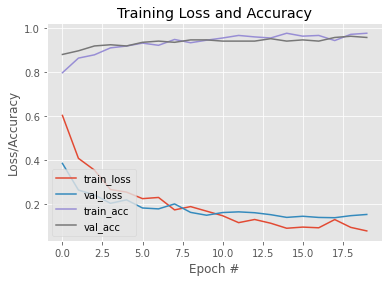

In [17]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

# Evaluate the model

In [50]:
'''
To evaluate our model, we use our model to predict the test data. 
Classification report is used to evaluate our model. 
Training Loss and Accuracy is plotted. 
'''

print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,
    target_names=lb.classes_))




[INFO] evaluating network...
                       precision    recall  f1-score   support

mask_weared_incorrect       1.00      0.83      0.91         6
            with_mask       0.97      1.00      0.98        62
         without_mask       1.00      0.90      0.95        10

             accuracy                           0.97        78
            macro avg       0.99      0.91      0.95        78
         weighted avg       0.98      0.97      0.97        78



In [59]:
'''
Save the model for future use purpose
'''
model.save("model2.h5")

# Using passport photo to test the model

In [20]:
'''
This function is to preprocess the input image so that we can input this image to the model we have trained. 
Using the MTCNN detector, we will first detect the number of faces inside the image. 
For each face detected, we will preprocess the face. 
This function will return a dictionary which consists of the list of faces contained inside the image and the 
coordinates of each faces detected in the iamge. 
'''

def preprocess_image(img_path):
    res = {'face_list': [], 'box': []}
    img = cv2.imread(img_path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detections = detector.detect_faces(img)

    for detection in detections:
        x, y, w, h = detection['box']
        # handling the bug inside MTCNN face detection
        if x < 0: 
            x = 0
        if y < 0: 
            y = 0
        if w < 0:
            w = 0
        if h < 0:
            h = 0
            
        box = x, y, w, h
#         print(img.shape)
#         print(box)
        face = img[y: y+h, x: x+w]
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        res['face_list'].append(face)
        res['box'].append(box)

    return res

In [21]:
'''
Load the model that we have trained previously. 
'''

from tensorflow import keras
model = keras.models.load_model("model2.h5")

In [6]:
'''
Creating output images for all the dataset image to see the performance of our model. 
Save the output images in another folder. 
'''

img_path = 'images/'
detector = MTCNN()
for image in os.listdir(img_path):
    print(image)
    passport_img = cv2.imread(img_path+image)
    passport_img = cv2.cvtColor(passport_img, cv2.COLOR_BGR2RGB)

    processed_img = preprocess_image(img_path+image)

    face_list = processed_img['face_list']
    box = processed_img['box']

    fig, ax = plt.subplots()
    ax.imshow(passport_img)

    for idx, face in enumerate(face_list):
        face = np.expand_dims(face, axis=0)
        pred = model.predict(face)

        if pred[0][0] > pred[0][1] and pred[0][0] > pred[0][2]:
            pred_class = "mask_weared_incorrect"
        elif pred[0][1] > pred[0][0] and pred[0][1] > pred[0][2]:
            pred_class = "with_mask"
        else:
            pred_class = "without_mask"

        x, y, w, h = box[idx]

        rect = patches.Rectangle((x, y),w, h, fill=False, color='purple', linewidth=2)
        ax.add_patch(rect)
        ax.text(x, y-10, pred_class, color='red')
    
    plt.axis("off")
    # Save the output image into png file
    plt.savefig("sample_output_images/output_" + image)
    plt.close()
# plt.grid()
# plt.show()
    

maksssksksss0.png
maksssksksss1.png
maksssksksss10.png
maksssksksss100.png
maksssksksss101.png
maksssksksss102.png
maksssksksss103.png
maksssksksss104.png
maksssksksss105.png
maksssksksss106.png
maksssksksss107.png
maksssksksss108.png
maksssksksss109.png
maksssksksss11.png
maksssksksss110.png
maksssksksss111.png
maksssksksss112.png
maksssksksss113.png
maksssksksss114.png
maksssksksss115.png
maksssksksss116.png
maksssksksss117.png
maksssksksss118.png
maksssksksss119.png
maksssksksss12.png
maksssksksss120.png
maksssksksss121.png
maksssksksss122.png
maksssksksss123.png
maksssksksss124.png
maksssksksss125.png
maksssksksss126.png
maksssksksss127.png
maksssksksss128.png
maksssksksss129.png
maksssksksss13.png
maksssksksss130.png
maksssksksss131.png
maksssksksss132.png
maksssksksss133.png
maksssksksss134.png
maksssksksss135.png
maksssksksss136.png
maksssksksss137.png
maksssksksss138.png
maksssksksss139.png
maksssksksss14.png
maksssksksss140.png
maksssksksss141.png
maksssksksss142.png
maksssksk

maksssksksss47.png
maksssksksss470.png
maksssksksss471.png
maksssksksss472.png
maksssksksss473.png
maksssksksss474.png
maksssksksss475.png
maksssksksss476.png
maksssksksss477.png
maksssksksss478.png
maksssksksss479.png
maksssksksss48.png
maksssksksss480.png
maksssksksss481.png
maksssksksss482.png
maksssksksss483.png
maksssksksss484.png
maksssksksss485.png
maksssksksss486.png
maksssksksss487.png
maksssksksss488.png
maksssksksss489.png
maksssksksss49.png
maksssksksss490.png
maksssksksss491.png
maksssksksss492.png
maksssksksss493.png
maksssksksss494.png
maksssksksss495.png
maksssksksss496.png
maksssksksss497.png
maksssksksss498.png
maksssksksss499.png
maksssksksss5.png
maksssksksss50.png
maksssksksss500.png
maksssksksss501.png
maksssksksss502.png
maksssksksss503.png
maksssksksss504.png
maksssksksss505.png
maksssksksss506.png
maksssksksss507.png
maksssksksss508.png
maksssksksss509.png
maksssksksss51.png
maksssksksss510.png
maksssksksss511.png
maksssksksss512.png
maksssksksss513.png
maksssk

maksssksksss840.png
maksssksksss841.png
maksssksksss842.png
maksssksksss843.png
maksssksksss844.png
maksssksksss845.png
maksssksksss846.png
maksssksksss847.png
maksssksksss848.png
maksssksksss849.png
maksssksksss85.png
maksssksksss850.png
maksssksksss851.png
maksssksksss852.png
maksssksksss86.png
maksssksksss87.png
maksssksksss88.png
maksssksksss89.png
maksssksksss9.png
maksssksksss90.png
maksssksksss91.png
maksssksksss92.png
maksssksksss93.png
maksssksksss94.png
maksssksksss95.png
maksssksksss96.png
maksssksksss97.png
maksssksksss98.png
maksssksksss99.png


In [23]:
detector = MTCNN()

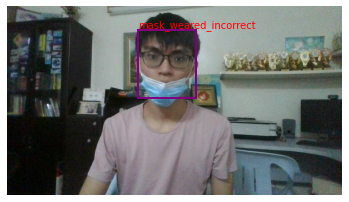

In [35]:
'''
Using the image path that we want, we can test our model. 
We can try using our passport photo to see whether the model is working. 
The workflow is as below: 
 1. The preprocess_image() function will extract the face list contained in the face. 
 2. The model that we have trained will classify whether the face is wearing mask, not wearing mask, or wearing mask incorrectly. 
 3. We will show our output using matplotlib. 
'''

img_path = 'TestImages/KohLiYang-MaskWornIncorrectly.jpg'
# detector = MTCNN()
image = "KohLiYang-MaskWornIncorrectly.jpg"
passport_img = cv2.imread(img_path)
passport_img = cv2.cvtColor(passport_img, cv2.COLOR_BGR2RGB)

processed_img = preprocess_image(img_path)

face_list = processed_img['face_list']
box = processed_img['box']

fig, ax = plt.subplots()
ax.imshow(passport_img)

for idx, face in enumerate(face_list):
    face = np.expand_dims(face, axis=0)
    pred = model.predict(face)

    if pred[0][0] > pred[0][1] and pred[0][0] > pred[0][2]:
        pred_class = "mask_weared_incorrect"
    elif pred[0][1] > pred[0][0] and pred[0][1] > pred[0][2]:
        pred_class = "with_mask"
    else:
        pred_class = "without_mask"

    x, y, w, h = box[idx]

    rect = patches.Rectangle((x, y),w, h, fill=False, color='purple', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y-10, pred_class, color='red')


plt.axis("off")
plt.grid("off")
# Save the output image into png file
plt.savefig("output_" + image)
plt.show()

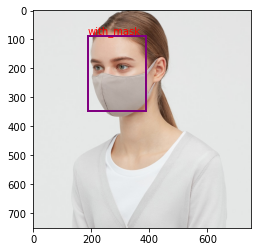

In [8]:
img_path = 'C:\\Users\\HP\\Desktop\\test.jpeg'

passport_img = cv2.imread(img_path)
passport_img = cv2.cvtColor(passport_img, cv2.COLOR_BGR2RGB)

processed_img = preprocess_image(img_path)

face_list = processed_img['face_list']
box = processed_img['box']

fig, ax = plt.subplots()
ax.imshow(passport_img)

for idx, face in enumerate(face_list):
    face = np.expand_dims(face, axis=0)
    pred = model.predict(face)

    if pred[0][0] > pred[0][1] and pred[0][0] > pred[0][2]:
        pred_class = "mask_weared_incorrect"
    elif pred[0][1] > pred[0][0] and pred[0][1] > pred[0][2]:
        pred_class = "with_mask"
    else:
        pred_class = "without_mask"

    x, y, w, h = box[idx]

    rect = patches.Rectangle((x, y),w, h, fill=False, color='purple', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y-10, pred_class, color='red')

# Save the output image into png file
# plt.savefig("sample_output_images/output_" + image)
# plt.close()
plt.show()